In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

import spacy

In [2]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)

In [3]:
mails = pd.read_csv('merged_datasets.csv')
categories = pd.CategoricalDtype(['safe', 'phishing'], ordered=True)
mails['label'] = mails['label'].astype(categories)

In [4]:
mails.drop_duplicates(subset=['subject', 'sender_mail'], keep='first', inplace=True)
mails.dropna(subset=['body', 'sender_mail'], inplace=True)

In [5]:
def extract_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    matches = re.findall(url_pattern, text)

    return matches, len(matches)


mails[['extracted_urls', 'urls_count']] = mails['body'].apply(lambda x: pd.Series(extract_urls(x)))

def map_url_lens(lens):
    if lens <= 2:
        return str(lens)
    else:
        return '3<='


mails['urls_count'] = mails['urls_count'].apply(map_url_lens)
categories = pd.CategoricalDtype(['0', '1', '2', '3<='], ordered=True)
mails['urls_count'] = mails['urls_count'].astype(categories)

In [6]:
# Jeżeli jeden url w mailu jest fałszywy, to wychodzimy z założenia, że inne też
def return_random_url(urls):
    urls_len = len(urls)
    if urls_len == 0:
        return None

    random_index = np.random.randint(0, urls_len)
    randomized_url = urls[random_index]
    return randomized_url

mails['in_body_url'] = mails['extracted_urls'].apply(return_random_url)

# TUTAJ NASTĘPUJE CIĘCIE USELESS WIERSZY

In [7]:
print(mails.shape)
mails.dropna(subset=['in_body_url'], inplace=True)
print(mails.shape)
print(mails.label.value_counts(normalize=True))

(87633, 8)
(41716, 8)
label
phishing    0.614944
safe        0.385056
Name: proportion, dtype: float64


In [8]:
def is_https(url):
    protocol = url[:5].lower()
    return 'https' if protocol == 'https' else 'http'


mails['protocol'] = mails['in_body_url'].apply(is_https)
categories = pd.CategoricalDtype(['http', 'https'], ordered=True)
mails['protocol'] = mails['protocol'].astype(categories)

In [9]:
def contains_ip(url):
    ip_pattern = re.compile(r'\b(?:\d{1,3}\.){3}\d{1,3}\b|\b(?:[0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}\b')
    ips = ip_pattern.findall(url)

    if ips:
        return True
    else:
        return False


mails['contains_ip'] = mails['in_body_url'].apply(contains_ip)
print(mails['contains_ip'].value_counts())

contains_ip
False    41558
True       158
Name: count, dtype: int64


In [10]:
mails['url_length'] = mails['in_body_url'].apply(len)

In [11]:
'''
POPRAWIĆ! nie ucina czasem domeny poprawnie

'''

def get_domain(url):
    pattern = re.compile(r'https?://([^/?]+)')
    match = pattern.match(url)
    if match:
        domain = match.group(1)
        if '/' in domain:
            return domain.split('/')[0]
        
        return domain
    else:
        return url


mails['domain'] = mails['in_body_url'].apply(get_domain)

In [12]:
def get_TLD(domain):
    split_domain = domain.split('.')
    n = len(split_domain)
    delimiters = ['/', ':', ')', ']', '%', '_', '=', ',', '>', '"', '#', '!']
    # Check if not weird ending
    after_dot = split_domain[n-1]
    if len(after_dot) > 2 and not after_dot.isalpha():
        after_dot = after_dot.split('/')[0]
        
        if len(after_dot) > 2 and not after_dot.isalpha():
            print(after_dot, 'INSIDE')
            for delimiter in delimiters:
                after_dot = " ".join(after_dot.split(delimiter))
            
            after_dot = after_dot.split()[0]

    TLD = '.'+after_dot.lower()
    return TLD


mails['TLD'] = mails['domain'].apply(get_TLD)

cat$ INSIDE
177 INSIDE
com:993 INSIDE
edu:11371 INSIDE
edu:11371 INSIDE
org:8010 INSIDE
uk) INSIDE
localhost:8880 INSIDE
tv", INSIDE
org:8010 INSIDE
org:8010 INSIDE
org:8010 INSIDE
org:8010 INSIDE
ca) INSIDE
domainname:80, INSIDE
com, INSIDE
com", INSIDE
com) INSIDE
domainname:80, INSIDE
domainname:8000 INSIDE
domainname:8000 INSIDE
org), INSIDE
org) INSIDE
org:8011 INSIDE
com, INSIDE
com)) INSIDE
bspace-dev-01 INSIDE
org) INSIDE
org) INSIDE
com) INSIDE
com! INSIDE
org) INSIDE
com, INSIDE
nz) INSIDE
com:8080 INSIDE
http: INSIDE
com") INSIDE
com) INSIDE
localhost:631 INSIDE
ie: INSIDE
ie: INSIDE
1:631 INSIDE
org, INSIDE
132 INSIDE
132 INSIDE
ie) INSIDE
132 INSIDE
132 INSIDE
132 INSIDE
132 INSIDE
htm) INSIDE
edu:8080 INSIDE
1:631 INSIDE
net), INSIDE
org) INSIDE
com) INSIDE
com, INSIDE
com, INSIDE
com) INSIDE
164 INSIDE
com"}) INSIDE
163 INSIDE
com), INSIDE
com), INSIDE
cz), INSIDE
html#ComleyDowe2005 INSIDE
pt) INSIDE
org* INSIDE
ie), INSIDE
com) INSIDE
jo, INSIDE
249:8080 INSIDE
uk; INS

In [13]:
def is_tld_alpha(tld):
    return tld[1:].isalpha()


mails['TLD_alpha'] = mails['TLD'].apply(is_tld_alpha)

In [14]:
def get_subdomain_level(domain):
    return domain.count('.')-1


def map_subdomain_lv(num):
    if num <= 5:
        return str(num)
    else:
        return '6<='


mails['subdomain_level'] = mails['domain'].apply(get_subdomain_level)
mails['subdomain_level'] = mails['subdomain_level'].apply(map_subdomain_lv)
categories = pd.CategoricalDtype(['0', '1', '2', '3<='], ordered=True)
mails['subdomain_level'] = mails['subdomain_level'].astype(categories)


print(mails['subdomain_level'].value_counts(normalize=True))

subdomain_level
1      0.628428
0      0.268645
2      0.102927
3<=    0.000000
Name: proportion, dtype: float64


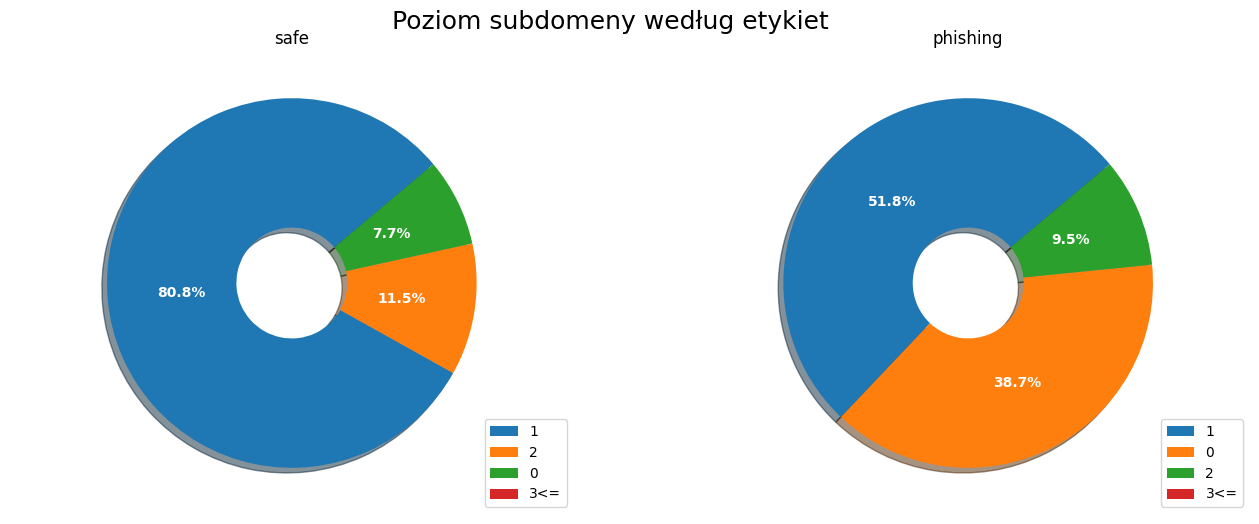

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# SAFE
legit_rows = mails[mails['label']=='safe']
dots_data = legit_rows['subdomain_level'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[0].axis('equal')
ax[0].set_title('safe')

wedges, texts, autotexts = ax[0].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[0].legend(wedges, labels, loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

# PHISHING
phishing_rows = mails[mails['label']=='phishing']
dots_data = phishing_rows['subdomain_level'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[1].axis('equal')
ax[1].set_title('phishing')

wedges, texts, autotexts = ax[1].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[1].legend(wedges, labels, loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

plt.suptitle('Poziom subdomeny według etykiet', fontsize=18, y=0.95)
plt.show()

In [16]:
print(mails.info(), end='\n\n')
print(mails['label'].value_counts(normalize=True), end='\n\n')
print(mails['protocol'].value_counts(normalize=True, dropna=False), end='\n\n')
print(mails['urls_count'].value_counts(normalize=True, dropna=False), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
Index: 41716 entries, 0 to 99469
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Unnamed: 0       41716 non-null  int64   
 1   sender_mail      41716 non-null  object  
 2   subject          41716 non-null  object  
 3   body             41716 non-null  object  
 4   label            41716 non-null  category
 5   extracted_urls   41716 non-null  object  
 6   urls_count       41716 non-null  category
 7   in_body_url      41716 non-null  object  
 8   protocol         41716 non-null  category
 9   contains_ip      41716 non-null  bool    
 10  url_length       41716 non-null  int64   
 11  domain           41716 non-null  object  
 12  TLD              41716 non-null  object  
 13  TLD_alpha        41716 non-null  bool    
 14  subdomain_level  41136 non-null  category
dtypes: bool(2), category(4), int64(2), object(7)
memory usage: 3.4+ MB
None

label
phishing    0

In [17]:
mails.drop(mails.columns[0], axis=1, inplace=True)

                               sender_mail  \
0                          Young@iworld.de   
1                   ipline's1983@icable.ph   
2  Karmandeep-opengevl@universalnet.psi.br   
3                        ivqrnai@pobox.com   
4         externalsep1@loanofficertool.com   

                                                                                                                                                  subject  \
0                                                                                                                               Never agree to be a loser   
1                                                                                                                                  Befriend Jenna Jameson   
2                                                                                                                                    CNN.com Daily Top 10   
3  Re: svn commit: r619753 - in /spamassassin/trunk: lib/Mail/SpamAssassin/PerMsgStatus.pm lib/

In [18]:
def count_slashes(url):
    return url.count('/')


def map_slashes(num):
    if num <= 5:
        return str(num)
    else:
        return '6<='



mails['slash_count'] = mails['in_body_url'].apply(count_slashes)

mails['slash_count'] = mails['slash_count'].apply(map_slashes)
categories = pd.CategoricalDtype(['0', '1', '2', '3', '4', '5', '6<='], ordered=True)
mails['slash_count'] = mails['slash_count'].astype(categories)

In [19]:
def count_dots(url):
    return url.count('.')


def map_dots(num):
    if num <= 4:
        return str(num)
    else:
        return '5<='


mails['dots_count'] = mails['in_body_url'].apply(count_dots)

mails['dots_count'] = mails['dots_count'].apply(map_dots)
categories = pd.CategoricalDtype(['0', '1', '2', '3', '4', '5<='], ordered=True)
mails['dots_count'] = mails['dots_count'].astype(categories)

In [20]:
def count_hyphens(url):
    return url.count('-')


def map_hyphens(num):
    if num <= 1:
        return str(num)
    else:
        return '2<='


mails['hyphens_count'] = mails['in_body_url'].apply(count_hyphens)

mails['hyphens_count'] = mails['hyphens_count'].apply(map_hyphens)
categories = pd.CategoricalDtype(['0', '1', '2<='], ordered=True)
mails['hyphens_count'] = mails['hyphens_count'].astype(categories)

In [24]:
print(mails.head(2))

              sender_mail                    subject  \
0         Young@iworld.de  Never agree to be a loser   
1  ipline's1983@icable.ph     Befriend Jenna Jameson   

                                                                                                                                                                                                      body  \
0  Buck up, your troubles caused by small dimension will soon be over!\nBecome a lover no woman will be able to resist!\nhttp://whitedone.com/\n\n\ncome. Even as Nazi tanks were rolling down the stre...   
1                                                                                                                   \nUpgrade your sex and pleasures with these techniques http://www.brightmade.com\n\n\n   

      label               extracted_urls urls_count  \
0  phishing      [http://whitedone.com/]          1   
1  phishing  [http://www.brightmade.com]          1   

                 in_body_url protocol  contain

In [25]:
print(mails.groupby('contains_ip').label.value_counts(normalize=True))

contains_ip  label   
False        phishing    0.613913
             safe        0.386087
True         phishing    0.886076
             safe        0.113924
Name: proportion, dtype: float64


In [26]:
print(mails.groupby('TLD_alpha').label.value_counts(normalize=True))

#print(mails.TLD.value_counts(normalize=True, ascending=True))

TLD_alpha  label   
False      safe        0.624484
           phishing    0.375516
True       phishing    0.619191
           safe        0.380809
Name: proportion, dtype: float64


In [27]:
#print(mails['TLD'].value_counts(normalize=True).sort_values())

In [28]:
import requests
from urllib.parse import urlparse

# def identify_redirects(url, max_redirects=3, max_parameters=5):
#     try:
#         response = requests.get(url, allow_redirects=False)
#         redirects = response.history

#         if len(redirects) > max_redirects:
#             return 'redirects'

#         parsed_url = urlparse(url)
#         query_parameters = parsed_url.query.split('&')
#         if len(query_parameters) > max_parameters:
#             return 'excessive_params'

#         return 'safe'

#     except requests.RequestException as e:
#         return None

# # Example usage
# mails['redirects'] = mails['in_body_url'].apply(identify_redirects)

In [29]:
from unidecode import unidecode


def has_non_latin_chars(url):
    ascii = unidecode(url)
    return url != ascii


url_to_check = "https://www.例子.com"  # URL with non-Latin characters (例子 means example in Chinese)
if has_non_latin_chars(url_to_check):
    print("Warning: Non-Latin characters detected. This may indicate phishing.")


mails['has_non_latin'] = mails['in_body_url'].apply(has_non_latin_chars)
print(mails['has_non_latin'].value_counts(normalize=True))

print(mails.groupby('has_non_latin').label.value_counts(normalize=True))


has_non_latin
False    0.997699
True     0.002301
Name: proportion, dtype: float64
has_non_latin  label   
False          phishing    0.614440
               safe        0.385560
True           phishing    0.833333
               safe        0.166667
Name: proportion, dtype: float64


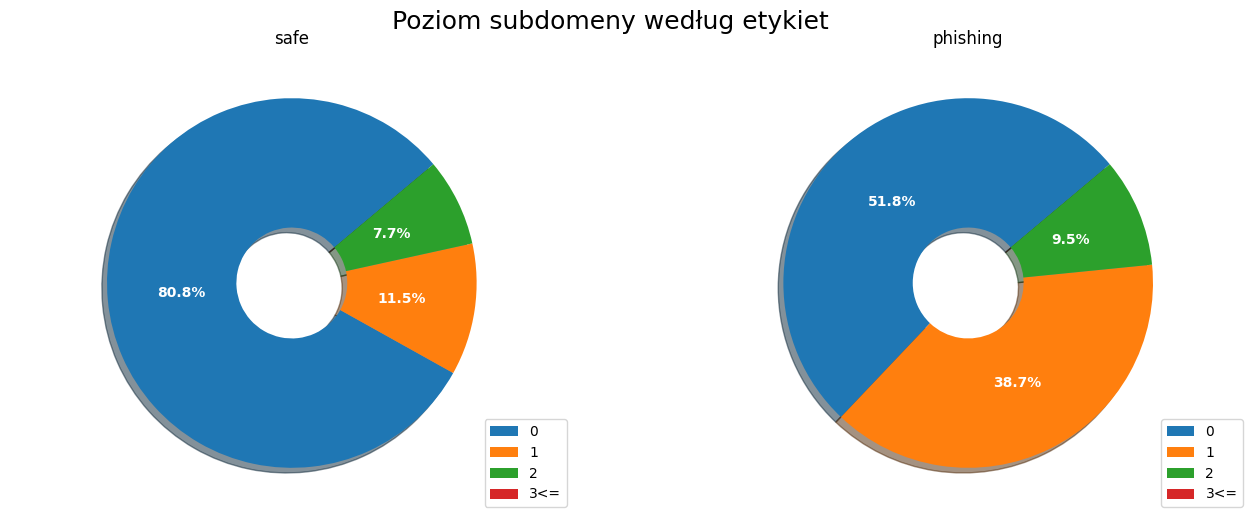

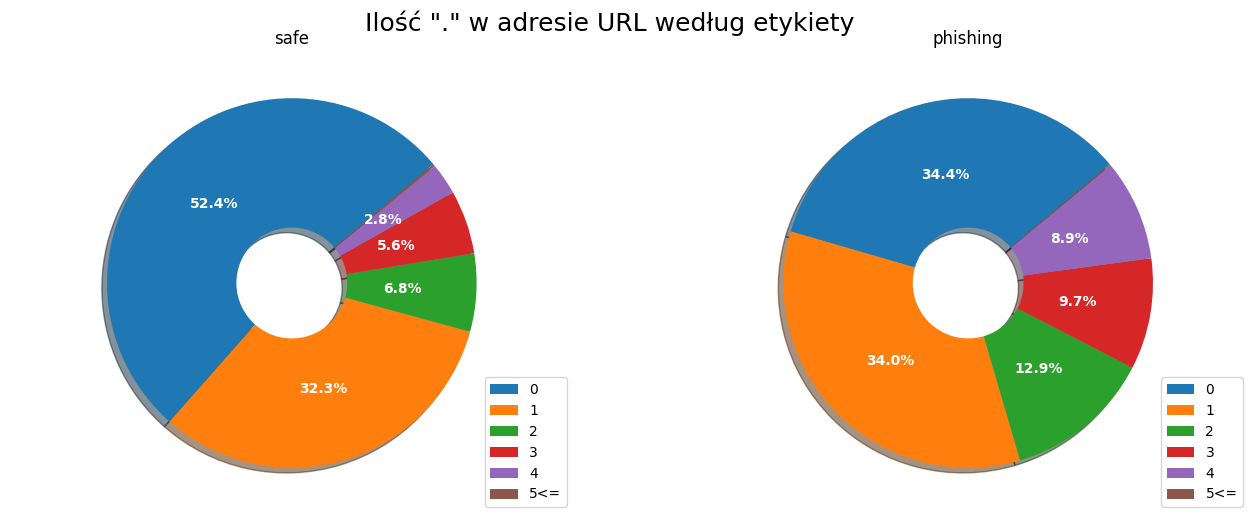

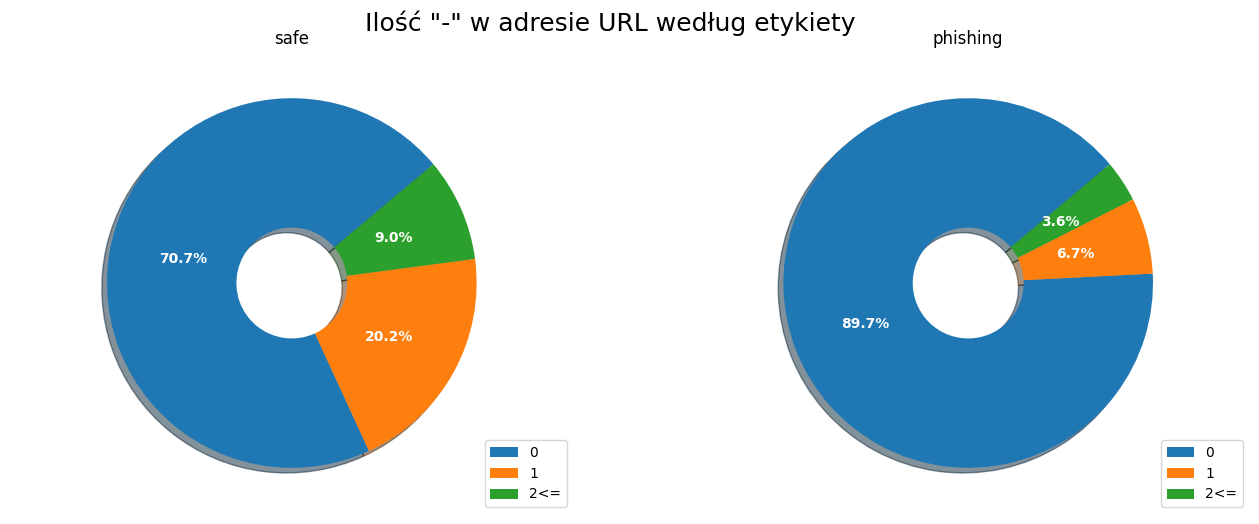

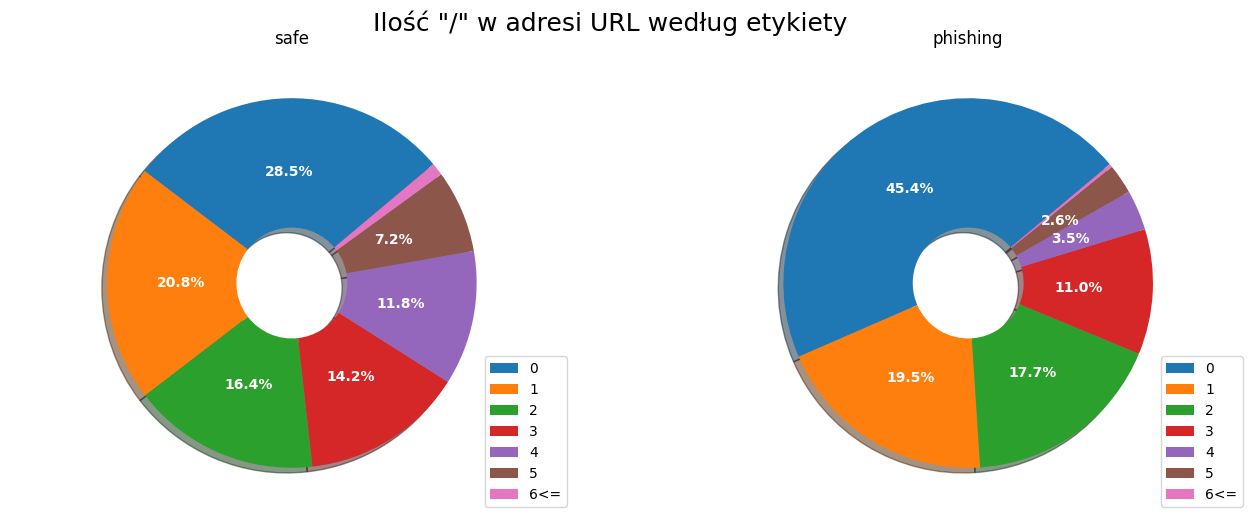

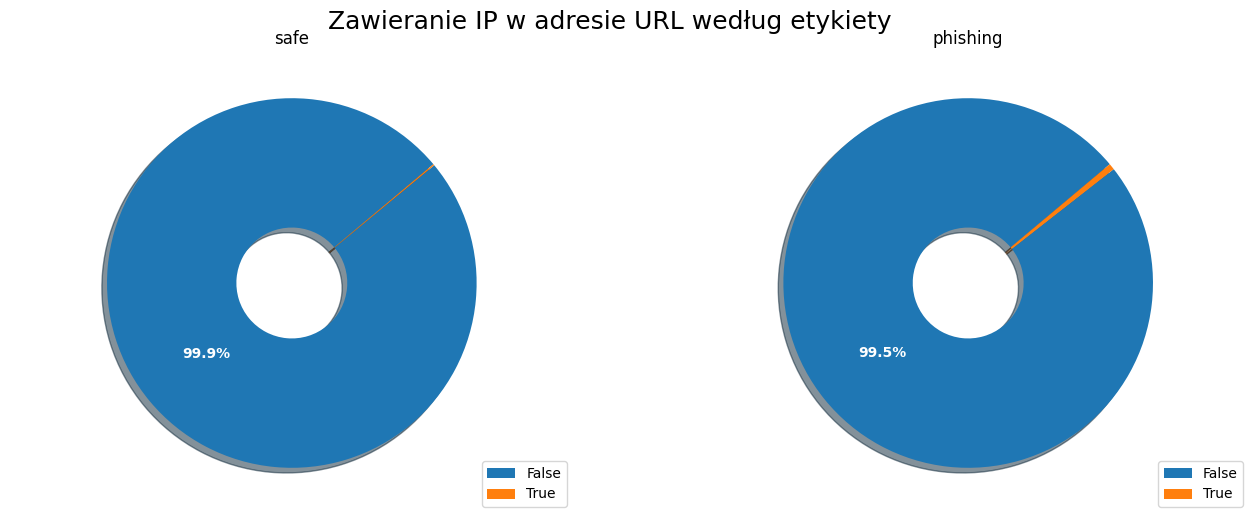

In [30]:
def make_pie_chart(col_name, chart_title=''):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    # SAFE
    legit_rows = mails[mails['label']=='safe']
    data = legit_rows[col_name].value_counts(normalize=True).to_dict()

    labels = list(data.keys())
    values = list(data.values())
    autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

    ax[0].axis('equal')
    ax[0].set_title('safe')

    wedges, texts, autotexts = ax[0].pie(x=values,
                                    wedgeprops=dict(width=0.70),
                                    autopct=autopct_format,
                                    shadow=True,
                                    startangle=40)

    ax[0].legend(wedges, sorted(labels), loc='lower right')
    plt.setp(autotexts, size=10, weight="bold", c='w')

    # PHISHING
    phishing_rows = mails[mails['label']=='phishing']
    data = phishing_rows[col_name].value_counts(normalize=True).to_dict()

    labels = list(data.keys())
    values = list(data.values())
    autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

    ax[1].axis('equal')
    ax[1].set_title('phishing')

    wedges, texts, autotexts = ax[1].pie(x=values,
                                    wedgeprops=dict(width=0.70),
                                    autopct=autopct_format,
                                    shadow=True,
                                    startangle=40)

    ax[1].legend(wedges, sorted(labels), loc='lower right')
    plt.setp(autotexts, size=10, weight="bold", c='w')

    plt.suptitle(chart_title, fontsize=18, y=0.95)


what_to_visualise = {
    'subdomain_level': 'Poziom subdomeny według etykiet',
    'dots_count': 'Ilość "." w adresie URL według etykiety',
    'hyphens_count': 'Ilość "-" w adresie URL według etykiety',
    'slash_count': 'Ilość "/" w adresi URL według etykiety',
    'contains_ip': 'Zawieranie IP w adresie URL według etykiety ZMIENIĆ KIERUNEK PORÓWNANIA',
    'has_non_latin': 'Zawieranie znaków spoza alfabetu łacińskiego w adresie URL według etykiety ZMIENIĆ KIERUNEK PORÓWNANIA'
}

for k, v in what_to_visualise.items():
    make_pie_chart(k, v)